<h1><center>Drawing Conclusions using Faculty Course Evaluations (FCE) and other Data</center></h1>

At the end of every semester, Carnegie Mellon University asks its students to complete Faculty Course Evaulations (FCEs). These evaluations gives the students the opportunity to rate the course and the professor by providing ratings (on a scale of 1 through 5) on various criterias such as 'Interest in Student Learning' and 'Demonstrate Importance of Subject Matter'. While many students merely use the FCE data to check how much hours one should commit to the class, this Jupyter Notebook will explore what other interesting questions we can ask using this data. Using the FCE data and other data gathered, we will be exploring the following questions:

* Does Professor Track and/or Title Have Anything to do FCE Ratings?
* Are Courses Offered in the Summer Rated Better than those Offered in the Year?
* How has the 'Hrs Per Week' changed over the years?
* Do higher level courses get rated higher than lower level courses?

Before we start our analysis, we first want to clean our FCE data.

## Getting Started
We will first start by importing the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import math

## Cleaning the FCE data
Let us first observe what our data looks like.

In [2]:
df = pd.read_csv("fce.csv")
df.head()

,Year,Semester,College,Dept,Course ID,Section,Name,Course Name,Level,Possible Respondents,...,Hrs Per Week 8,Interest in student learning,Clearly explain course requirements,Clear learning objectives & goals,Instructor provides feedback to students to improve,Demonstrate importance of subject matter,Explains subject matter of course,Show respect for all students,Overall teaching rate,Overall course rate
0,2019,Fall,College of Fine Arts,ARC,48358,B1,"BEN-ALON, RACHEL",EARTHEN BUILDING,Undergraduate,26,...,NaN,4.79,4.62,4.57,4.69,4.57,4.71,4.93,4.71,4.71
1,2019,Fall,College of Fine Arts,ARC,48358,A1,"BEN-ALON, RACHEL",EARTHEN BUILDING,Undergraduate,8,...,NaN,5.00,5.00,4.83,4.83,5.00,4.83,5.00,4.33,4.17
2,2019,Fall,College of Fine Arts,ARC,48689,A1,"KIM, MAN",DIGI SKLLS WRKSHP,Graduate,14,...,NaN,4.75,4.63,4.75,4.88,4.50,4.75,4.63,4.75,4.38
3,2019,Fall,College of Fine Arts,ARC,48753,A1,"DAWKINS, MARANTHA",INTRO UD MED,Graduate,14,...,NaN,4.00,3.00,3.60,4.40,3.60,3.40,4.60,3.60,3.20
4,2019,Fall,College of Fine Arts,ART,60131,A1,"GURYSH, STEVEN",3D MEDIA STUDIO I,Undergraduate,11,...,NaN,4.88,4.63,4.86,4.86,4.57,4.86,5.00,4.86,4.71


In [3]:
print(df.isna().sum())

Year                                                       0
Semester                                                   0
College                                                    0
Dept                                                       0
Course ID                                                  0
Section                                                    0
Name                                                       1
Course Name                                                0
Level                                                      0
Possible Respondents                                       0
Num Respondents                                            0
Response Rate %                                            0
Hrs Per Week                                           20635
Hrs Per Week 5                                         37504
Hrs Per Week 8                                         42744
Interest in student learning                            1661
Clearly explain course r

Let us clean our data to make it easier to process. There seems to a row where "Name" has a value of NaN. We will drop this row.

In [4]:
df = df[pd.notnull(df['Name'])]  # Dropping the rows with column 'Name' = NaN 

There seems to be a lot of NaN values for columns 'Hrs Per Week 5' and 'Hrs Per Week 8', so we will drop those columns. For the remaining columns with NaN values, we will replace those values with the mean of their respective column

In [5]:
df = df[df["College"] != "Teaching Assistants"]
if "Hrs Per Week 5" in df.columns and "Hrs Per Week 8" in df.columns:
    df = df.drop(columns=["Hrs Per Week 5", "Hrs Per Week 8"])

Let us verify we do not have any more NaN values.

In [6]:
lst = df.columns[df.isnull().any()].tolist()
df[lst] = df[lst].fillna(df[lst].mean())
print(df.isna().sum())

Year                                                   0
Semester                                               0
College                                                0
Dept                                                   0
Course ID                                              0
Section                                                0
Name                                                   0
Course Name                                            0
Level                                                  0
Possible Respondents                                   0
Num Respondents                                        0
Response Rate %                                        0
Hrs Per Week                                           0
Interest in student learning                           0
Clearly explain course requirements                    0
Clear learning objectives & goals                      0
Instructor provides feedback to students to improve    0
Demonstrate importance of subje

Now that we have cleaned up the FCE data, let us use this to ask questions about Carnegie Mellon Courses and Faculty.

## Average FCE Hours By Department
We are curious about the average FCE hours by department. Let us create a visualization to see which department tends to have the highest FCE hours.

9.568600041506796


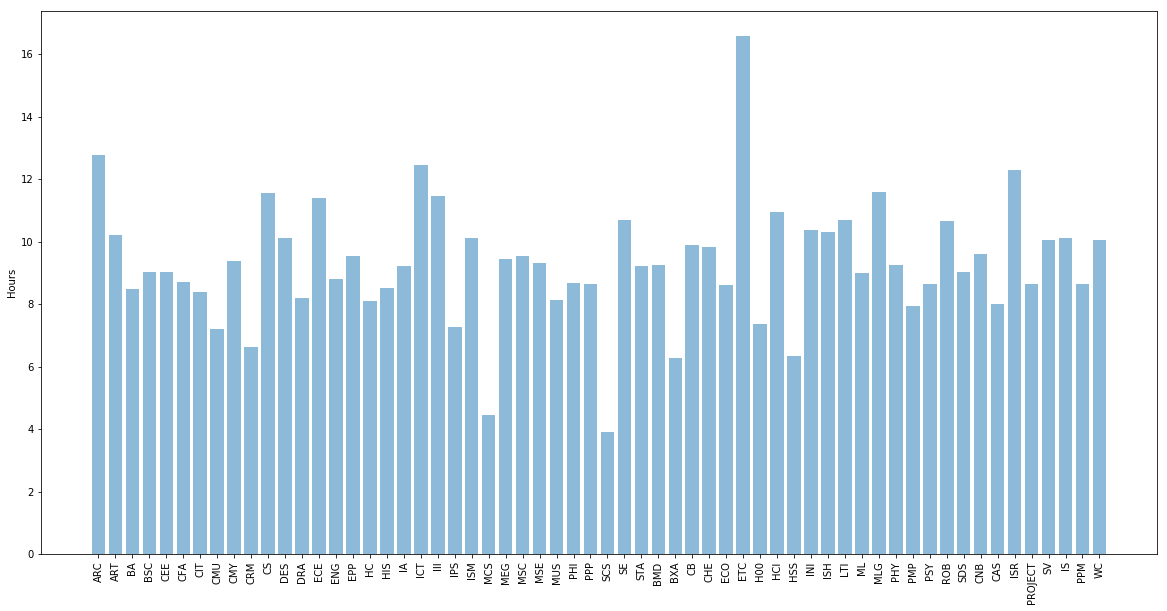

In [7]:
department_id = {}

for index, row in df.iterrows():
    if row["Dept"] not in department_id:
        department_id[row["Dept"]] = row["Course ID"][0:2]
        
id_list = []
hour_list = []

for ids in department_id:
    id_list.append(ids)
    hour_list.append(df[df["Course ID"].str.startswith(department_id[ids])]["Hrs Per Week"].mean())

print(df["Hrs Per Week"].mean())
    
pos = [hour[0] for hour in enumerate(hour_list)]

plt.figure(figsize=(20,10))
plt.bar(pos, hour_list, align='center', alpha=0.5)
plt.xticks(pos, id_list)
plt.xticks(rotation=90)
plt.ylabel('Hours')

plt.show()

## Does Professor Track and/or Title Have Anything to do FCE Ratings?

Professorships have titles and tracks. 


In [8]:
def process_name(s):
    name_str = s.upper()
    name = name_str.split(" ")
    return name[1] + ", " + name[0]


def getTeachingVsTenure(csv):
    teaching = csv[csv['Title'].str.contains("Teaching", na=False)]
    tenure_temp = csv[~csv['Title'].str.contains("Teaching", na=False)]
    tenure = tenure_temp[tenure_temp['Title'].str.contains("Professor", na=False)]
    teaching_faculty = {}
    tenure_faculty = {}
    for x in teaching["Name"]:
        person = csv[csv["Name"] == x]
        rating = float(person["Overall teaching rate"].mean())
        if not math.isnan(rating): teaching_faculty[x] = rating

    for x in tenure["Name"]:
        person = csv[csv["Name"] == x]
        rating = float(person["Overall teaching rate"].mean())
        if not math.isnan(rating): tenure_faculty[x] = rating
    
    teachingList = [teaching_faculty[x] for x in teaching_faculty]
    tenureList = [tenure_faculty[x] for x in tenure_faculty]
    return teachingList, tenureList

We will massage the data for Dietrich, Heinz, and SCS

In [9]:
import os.path
df_prof = df.copy()
df_prof["Name"] = df_prof["Name"].str.replace(",", "")

df_2019Heinz = df_prof[(df_prof["Year"] == 2019) & (df_prof["College"] == "Heinz College")]
lst_Heinz_2019 = df_2019Heinz["Name"].unique()
if not os.path.exists("Heinz2019.csv"):
    print("Creating Heinz 2019 faculty list...", end="")
    pd.DataFrame(lst_Heinz_2019).to_csv("Heinz2019.csv")
    print("Done!")
    
df_2019Dietrich = df_prof[(df_prof["Year"] == 2019) & (df_prof["College"] == " Dietrich College of Humanities and Social Sciences")]
lst_Dietrich_2019 = df_2019Dietrich["Name"].unique()
if not os.path.exists("Dietrich2019.csv"):
    print("Creating Dietrich 2019 faculty list...", end="")
    pd.DataFrame(lst_Dietrich_2019).to_csv("Dietrich2019.csv")
    print("Done!")
    
df_2019SCS = df_prof[(df_prof["Year"] == 2019) & (df_prof["College"] == " School of Computer Science")]
lst_SCS_2019 = df_2019SCS["Name"].unique()
if not os.path.exists("SCS2019.csv"):
    print("Creating SCS 2019 faculty list...", end="")
    pd.DataFrame(lst_SCS_2019).to_csv("SCS2019.csv")
    print("Done!")
    
df_2019MCS = df_prof[(df_prof["Year"] == 2019) & (df_prof["College"] == " Mellon College of Science")]
lst_MCS_2019 = df_2019MCS["Name"].unique()
if not os.path.exists("MCS2019.csv"):
    print("Creating MCS 2019 faculty list...", end="")
    pd.DataFrame(lst_MCS_2019).to_csv("MCS2019.csv")
    print("Done!")
    
df_2019CIT = df_prof[(df_prof["Year"] == 2019) & (df_prof["College"] == " Carnegie Institute of Technology")]
lst_CIT_2019 = df_2019CIT["Name"].unique()
if not os.path.exists("CIT2019.csv"):
    print("Creating CIT 2019 faculty list...", end="")
    pd.DataFrame(lst_CIT_2019).to_csv("CIT2019.csv")
    print("Done!")
    
df_2019CFA = df_prof[(df_prof["Year"] == 2019) & (df_prof["College"] == " College of Fine Arts")]
lst_CFA_2019 = df_2019CFA["Name"].unique()
if not os.path.exists("CFA2019.csv"):
    print("Creating CFA 2019 faculty list...", end="")
    pd.DataFrame(lst_CFA_2019).to_csv("CFA2019.csv")
    print("Done!")
    
df_2019TPR = df_prof[(df_prof["Year"] == 2019) & (df_prof["College"] == " Tepper School of Business")]
lst_TPR_2019 = df_2019TPR["Name"].unique()
if not os.path.exists("TPR2019.csv"):
    print("Creating TPR 2019 faculty list...", end="")
    pd.DataFrame(lst_TPR_2019).to_csv("TPR2019.csv")
    print("Done!")

In [10]:
scraped_lst = ["Scraped_Dietrich2019.csv", "Scraped_Heinz2019.csv", 
               "Scraped_SCS2019.csv", "Scraped_MCS2019.csv", "Scraped_CIT2019.csv", 
                   "Scraped_CFA2019.csv", "Scraped_TPR2019.csv"]
name_lst = ["Dietrich2019.csv", "Heinz2019.csv", "SCS2019.csv", "MCS2019.csv", "CIT2019.csv", "CFA2019.csv", "TPR2019.csv"]

In [11]:
df_2019Heinz_info = df_2019Heinz[["Name", "Overall teaching rate"]]
df_2019Heinz_info.reset_index(inplace=True,drop=True)

df_2019Dietrich_info = df_2019Dietrich[["Name", "Overall teaching rate"]]
df_2019Dietrich_info.reset_index(inplace=True,drop=True)

df_2019SCS_info = df_2019SCS[["Name", "Overall teaching rate"]]
df_2019SCS_info.reset_index(inplace=True,drop=True)

df_2019MCS_info = df_2019MCS[["Name", "Overall teaching rate"]]
df_2019MCS_info.reset_index(inplace=True,drop=True)

df_2019CIT_info = df_2019CIT[["Name", "Overall teaching rate"]]
df_2019CIT_info.reset_index(inplace=True,drop=True)

df_2019CFA_info = df_2019CFA[["Name", "Overall teaching rate"]]
df_2019CFA_info.reset_index(inplace=True,drop=True)

df_2019TPR_info = df_2019TPR[["Name", "Overall teaching rate"]]
df_2019TPR_info.reset_index(inplace=True,drop=True)

df_2019Dietrich_info = df_2019Dietrich_info.groupby(["Name"]).mean()
df_2019Heinz_info = df_2019Heinz_info.groupby(["Name"]).mean()
df_2019SCS_info = df_2019SCS_info.groupby(["Name"]).mean()
df_2019MCS_info = df_2019MCS_info.groupby(["Name"]).mean()
df_2019CIT_info = df_2019CIT_info.groupby(["Name"]).mean()
df_2019CFA_info = df_2019CFA_info.groupby(["Name"]).mean()
df_2019TPR_info = df_2019CFA_info.groupby(["Name"]).mean()

df_2019Dietrich_info = df_2019Dietrich_info.reset_index()
df_2019Heinz_info = df_2019Heinz_info.reset_index()
df_2019SCS_info = df_2019SCS_info.reset_index()
df_2019MCS_info = df_2019MCS_info.reset_index()
df_2019CIT_info = df_2019CIT_info.reset_index()
df_2019CFA_info = df_2019CFA_info.reset_index()
df_2019TPR_info = df_2019CFA_info.reset_index()

In [12]:
# df_2019Heinz_info

In [13]:
def f(s):
    s = s.replace("\n", " ")
    if ("Select a name below" in s) or ("You have reached the search limit" in s) or \
       ("No exact matches" in s):
        return "Error"
    s1 = "Job Title According to HR:"
    s2 = "Department with which this person is affiliated:"
    ind1 = s.find(s1) + len(s1)
    ind2 = s.find(s2)
    return s[ind1:ind2]

In [14]:
# scraped_dietrich_df = pd.read_excel(scraped_lst[0])
scraped_dietrich_df = pd.read_csv(scraped_lst[0])

scraped_dietrich_df["Title"] = scraped_dietrich_df["Info"].apply(f)

df_2019Dietrich_info_merged = df_2019Dietrich_info.merge(scraped_dietrich_df, how="outer", left_index=True,right_index=True)
if ("ItemID" in df_2019Dietrich_info_merged.columns) and ("Info" in df_2019Dietrich_info_merged.columns):
    df_2019Dietrich_info_merged = df_2019Dietrich_info_merged.drop(columns=["ItemID", "Info"])

In [15]:
# scraped_heinz_df = pd.read_excel(scraped_lst[1])
scraped_heinz_df = pd.read_csv(scraped_lst[1])

scraped_heinz_df["Title"] = scraped_heinz_df["Info"].apply(f)

df_2019Heinz_info_merged = df_2019Heinz_info.merge(scraped_heinz_df, how="outer", left_index=True,right_index=True)
if ("ItemID" in df_2019Heinz_info_merged.columns) and ("Info" in df_2019Heinz_info_merged.columns):
    df_2019Heinz_info_merged = df_2019Heinz_info_merged.drop(columns=["ItemID", "Info"])

In [16]:
# scraped_scs_df = pd.read_excel(scraped_lst[2])
scraped_scs_df = pd.read_csv(scraped_lst[2])

scraped_scs_df["Title"] = scraped_scs_df["Info"].apply(f)

df_2019SCS_info_merged = df_2019SCS_info.merge(scraped_scs_df, how="outer", left_index=True,right_index=True)
if ("ItemID" in df_2019SCS_info_merged.columns) and ("Info" in df_2019SCS_info_merged.columns):
    df_2019SCS_info_merged = df_2019SCS_info_merged.drop(columns=["ItemID", "Info"])

In [17]:
scraped_mcs_df = pd.read_csv(scraped_lst[3])

scraped_mcs_df["Title"] = scraped_mcs_df["Info"].apply(f)

df_2019MCS_info_merged = df_2019MCS_info.merge(scraped_mcs_df, how="outer", left_index=True,right_index=True)
if ("ItemID" in df_2019MCS_info_merged.columns) and ("Info" in df_2019MCS_info_merged.columns):
    df_2019MCS_info_merged = df_2019MCS_info_merged.drop(columns=["ItemID", "Info"])
df_2019MCS_info

,Name,Overall teaching rate
0,AFFARA NESRINE,4.540
1,ALBA WILLIAM,4.605
2,ALISON JOHN,4.000
3,ANDERSON DAVID,4.982
4,AOUN CHADI,5.000
...,...,...
147,YOUNIS IHAB,3.710
148,YTTRI ERIC,4.045
149,ZAYED MOHAMED,4.550
150,ZHAO YONGXIN,3.330


In [18]:
scraped_cit_df = pd.read_csv(scraped_lst[4])

scraped_cit_df["Title"] = scraped_cit_df["Info"].apply(f)

df_2019CIT_info_merged = df_2019CIT_info.merge(scraped_cit_df, how="outer", left_index=True,right_index=True)
if ("ItemID" in df_2019CIT_info_merged.columns) and ("Info" in df_2019CIT_info_merged.columns):
    df_2019CIT_info_merged = df_2019CIT_info_merged.drop(columns=["ItemID", "Info"])
df_2019CIT_info

,Name,Overall teaching rate
0,ABBOTT-BEAUREGARD ROSALYN,4.910000
1,ACHARYA AMIT,3.735000
2,ADAMS PETER,4.780000
3,ALDERUCCI Dean,4.810000
4,AMVROSIADIS GEORGIOS,4.290000
...,...,...
244,ZHAI HAIBO,3.830000
245,ZHANG JIA,3.596667
246,ZHANG PEI,4.465000
247,ZHANG YONGJIE,4.010000


In [19]:
scraped_cfa_df = pd.read_csv(scraped_lst[5])

scraped_cfa_df["Title"] = scraped_cfa_df["Info"].apply(f)

df_2019CFA_info_merged = df_2019CFA_info.merge(scraped_cfa_df, how="outer", left_index=True,right_index=True)
if ("ItemID" in df_2019CFA_info_merged.columns) and ("Info" in df_2019CFA_info_merged.columns):
    df_2019CFA_info_merged = df_2019CFA_info_merged.drop(columns=["ItemID", "Info"])
df_2019CFA_info

,Name,Overall teaching rate
0,ABREU MARIA,4.50
1,AHLSTEDT DOUGLAS,5.00
2,AKIN OMER,5.00
3,ALMARZA ALBERTO,5.00
4,AMATO DONNA,5.00
...,...,...
304,ZACHARIAS ROBERT,4.75
305,ZAMBORSKY BETH,4.50
306,ZEGLIN GARTH,3.25
307,ZIMMERER Nicole,4.00


In [20]:
scraped_tpr_df = pd.read_csv(scraped_lst[6])

scraped_tpr_df["Title"] = scraped_tpr_df["Info"].apply(f)

df_2019TPR_info_merged = df_2019TPR_info.merge(scraped_tpr_df, how="outer", left_index=True,right_index=True)
if ("ItemID" in df_2019TPR_info_merged.columns) and ("Info" in df_2019TPR_info_merged.columns):
    df_2019TPR_info_merged = df_2019TPR_info_merged.drop(columns=["ItemID", "Info"])
df_2019TPR_info

,index,Name,Overall teaching rate
0,0,ABREU MARIA,4.50
1,1,AHLSTEDT DOUGLAS,5.00
2,2,AKIN OMER,5.00
3,3,ALMARZA ALBERTO,5.00
4,4,AMATO DONNA,5.00
...,...,...,...
304,304,ZACHARIAS ROBERT,4.75
305,305,ZAMBORSKY BETH,4.50
306,306,ZEGLIN GARTH,3.25
307,307,ZIMMERER Nicole,4.00


MCS 4.242419047619048 4.229179104477612
Dietrich 4.2497865497076015 4.374986531986532
SCS 4.310331250000001 4.194392207792207
Heinz 4.199020833333333 4.068373422873423
CIT 4.221316666666667 4.2923376436781595
CFA 4.288968253968254 4.479724965646314
TPR 4.352731481481481 4.269341867903387


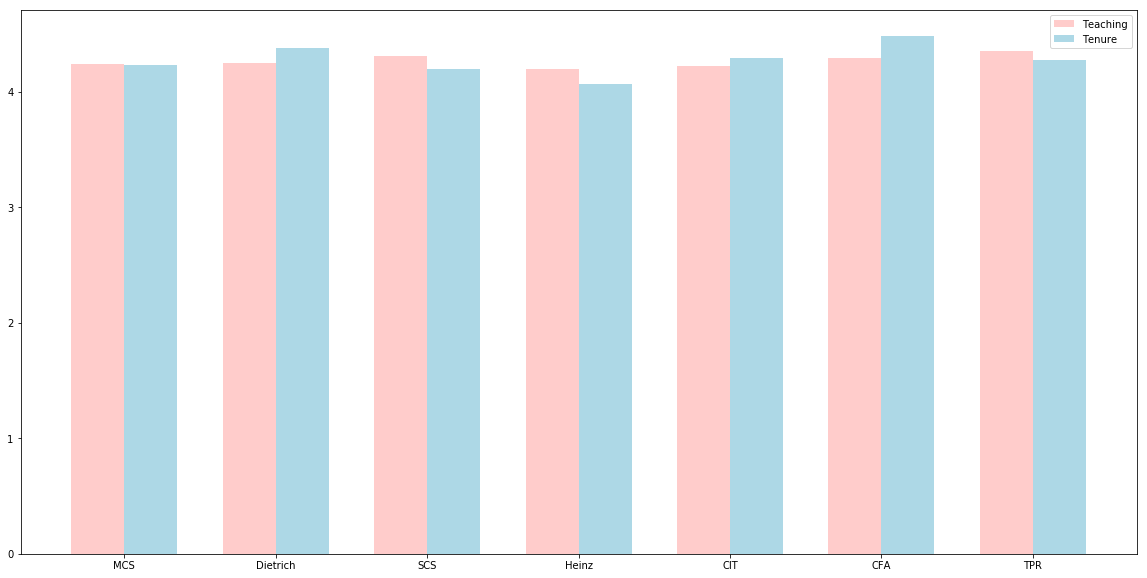

In [21]:
schools = ["MCS", "Dietrich", "SCS", "Heinz", "CIT", "CFA", "TPR"]
csvs = [df_2019MCS_info_merged, df_2019Dietrich_info_merged, df_2019SCS_info_merged, 
        df_2019Heinz_info_merged, df_2019CIT_info_merged, df_2019CFA_info_merged, df_2019TPR_info_merged]

teachList = []
tenureList = []

for file in csvs:
    teaching, tenure = getTeachingVsTenure(file)
    teachList.append(sum(teaching)/len(teaching))
    tenureList.append(sum(tenure)/len(tenure))
    
N = len(schools)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
bar1 = ax.bar(ind, teachList, width, color='#ffcccb')
bar2 = ax.bar(ind + width, tenureList, width, color='#add8e6')

# add some text for labels, title and axes ticks
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(schools)

for x in range(len(teachList)):
    print(schools[x], teachList[x], tenureList[x])


ax.legend((bar1[0], bar2[0]), ('Teaching', 'Tenure'))

plt.show()

## Are Summer Courses Better than Year Courses?


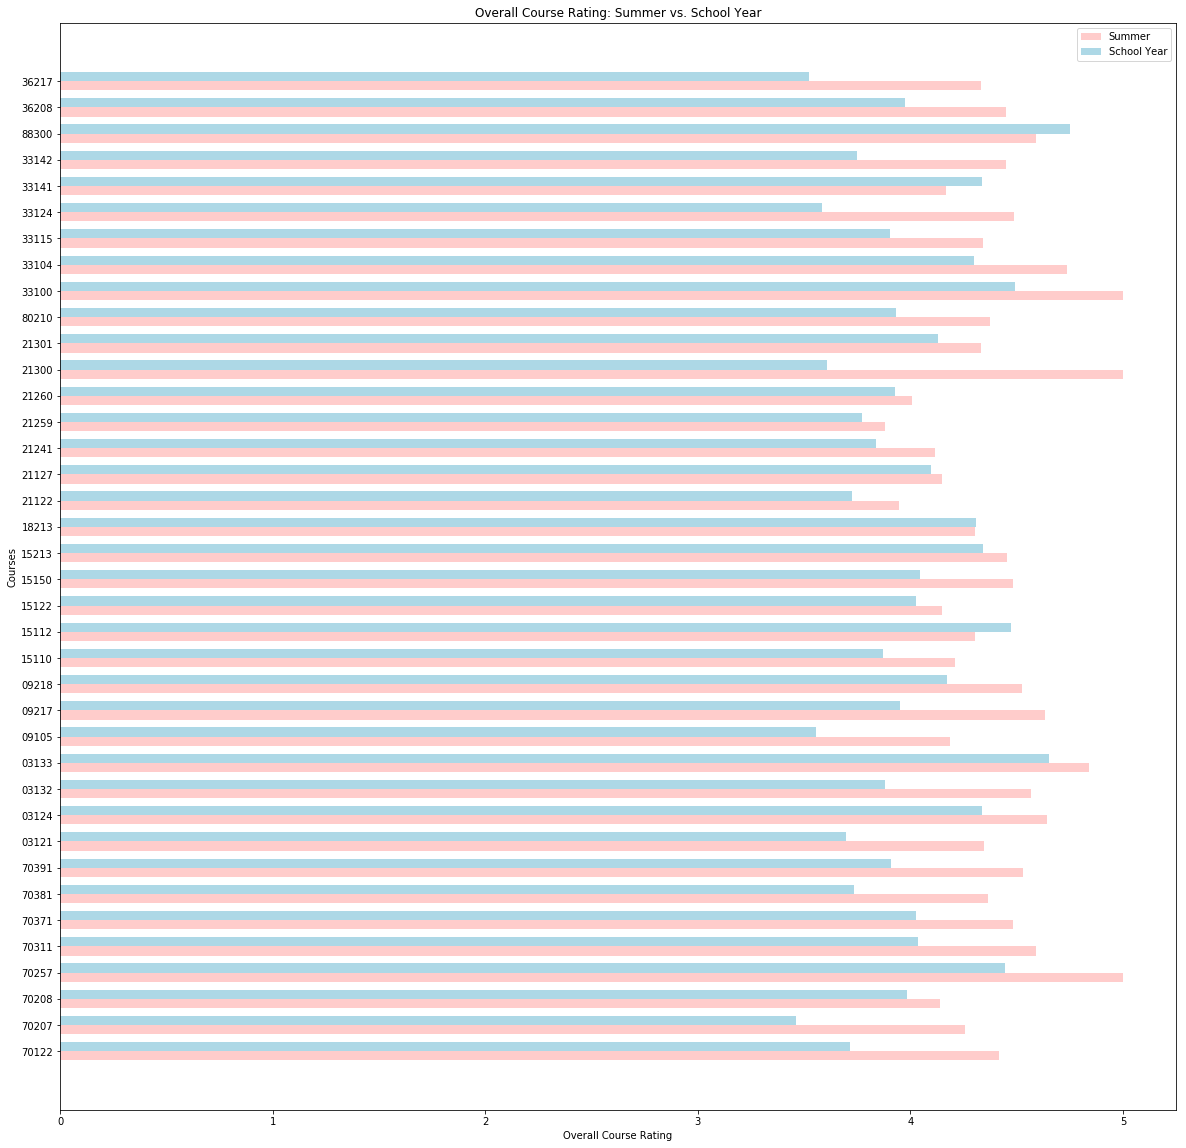

In [22]:
df_summer = df[df['Semester'] == "Summer"]
df_year = df[df['Semester'] != "Summer"]

courses = open("summer_courses_id.txt", "r").read().split()

ratings = [0,1,2,3,4,5]
summer_rate = []
year_rate = []

for cls in courses:
    summer_rate.append(df_summer[df_summer['Course ID'] == cls]["Overall course rate"].mean())
    year_rate.append(df_year[df_year['Course ID'] == cls]["Overall course rate"].mean())

N = len(courses)
summer = summer_rate

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(20, 20))
bar1 = ax.barh(ind, summer, width, color='#ffcccb')

year = year_rate
bar2 = ax.barh(ind + width, year, width, color='#add8e6')

# add some text for labels, title and axes ticks
ax.set_xlabel('Overall Course Rating')
ax.set_ylabel('Courses')
ax.set_title("Overall Course Rating: Summer vs. School Year")
ax.set_yticks(ind + width / 2)
ax.set_xticklabels(ratings)
ax.set_yticklabels(courses)

ax.legend((bar1[0], bar2[0]), ('Summer', 'School Year'))

plt.show()

## Paired Sample T-test
We wish to perform a paired sample t-test for the summer ratings and semester ratings to see if the group means are significantly different, because the summer ratings and the year ratings are dependent for the same course. 

Recall that: <br>

**Null Hypothesis( $H_0$ )** is that the mean difference between summer ratings and semester ratings is zero. <br>
**Alternative Hypothesis( $H_A$ )** is that the mean difference between summer ratings and semester ratings is **not** equal to zero.

Thus, we first check the **assumptions** for the paired sample t-test.

* The dependent variable must be continuous 
    * We know this is **satisfied** because rating of a class is equal to the mean of all the ratings of the same class, and thus rating $\in$ [0, 5]
* Dependent observations
    * We want to check that the subjects for the groups are the same, this is **satisfied** because the summer ratings and semester ratings corresponds to the same classes.
* Normal distribution of the difference of the two groups
    * This is **satisfied** (see graph below).
* Random sample of data from the population


Text(0.5, 1.0, 'QQ-plot for determining Normality')

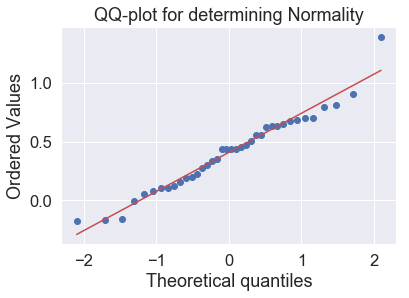

In [50]:
## Test for Normality of Residuals

diff = [summer_rate[i] - year_rate[i] for i in range(len(summer_rate))]
stats.probplot(diff,plot=plt)
plt.title("QQ-plot for determining Normality")
# plt.boxplot(diff)

From the QQ-plot, we can see that the data points are mostly on the red line, meaning that
the **normality assumption** is also satisfied.

However, we noticed that we **cannot** guarentee that the data points are randomly selected.
We cannot determine whether the mean of one group is statistically significally larger
than the other group, so instead we present the difference of both groups here. <br>

In [63]:
df_both_courses = pd.DataFrame(list(zip(summer_rate, year_rate)), columns=["Summer", "Semester"])
df_both_courses["diff(Summer-Semester)"] = df_both_courses["Summer"] - df_both_courses["Semester"]
df_both_courses.mean()

Summer                   4.415247
Semester                 4.007100
diff(Summer-Semester)    0.408147
dtype: float64

We can see that the mean for difference between summer raings and semester ratings is 0.4 > 0. We can conclude that on average, for the same course offered both in summer and the semester, the summer rating is higher than the semester year rating.

In [51]:
## Test for Homogeneity of variances

# from scipy import stats
# # 'summer_rate' and 'year_rate' are the two groups of data points that we are looking at.
# # We perform a Levene's Test to check for the homogeneity of variance between summer_rate and year_rate.
# stats.levene(summer_rate, year_rate)

In [52]:
# We can see that the p-value > 0.05, meaning that the test is not significant. 
# By the construction of the **Levene's Test**, this indicates that **the variances are not significantly
# different**, which means we can confirm that 
# **the homeogeneity of variance assumption is satisfied**.

In [ ]:
### Independent T-test



## Professor Titles

In [23]:
# 0 = Professors
# 1 = Associate
# 2 = Assistant
# 3 = Student
def getTitle(csv, title: int):
    if title < 0 or title > 4:
        return []
    if title == 0:
        professors = csv[(~csv['Title'].str.contains("Associate", na=False)) & 
                         (csv['Title'].str.contains("Professor", na=False)) & 
                        ~(csv['Title'].str.contains("Assistant", na=False))]
    elif title == 1:
        professors = csv[(csv['Title'].str.contains("Associate", na=False)) & 
                         (csv['Title'].str.contains("Professor", na=False)) & 
                        ~(csv['Title'].str.contains("Assistant", na=False))]
    elif title == 2: 
        professors = csv[(~csv['Title'].str.contains("Associate", na=False)) & 
                         (csv['Title'].str.contains("Professor", na=False)) & 
                        (csv['Title'].str.contains("Assistant", na=False))]
    else:
        professors = csv[(csv['Title'].str.contains("Job", na=False)) & 
                         (csv['Title'].str.contains("Student", na=False))]
    output_dict = {}
    for x in professors["Name"]:
        person = csv[csv["Name"] == x]
        rating = float(person["Overall teaching rate"].mean())
        if not math.isnan(rating): output_dict[x] = rating
    output = [output_dict[x] for x in output_dict]
    return output



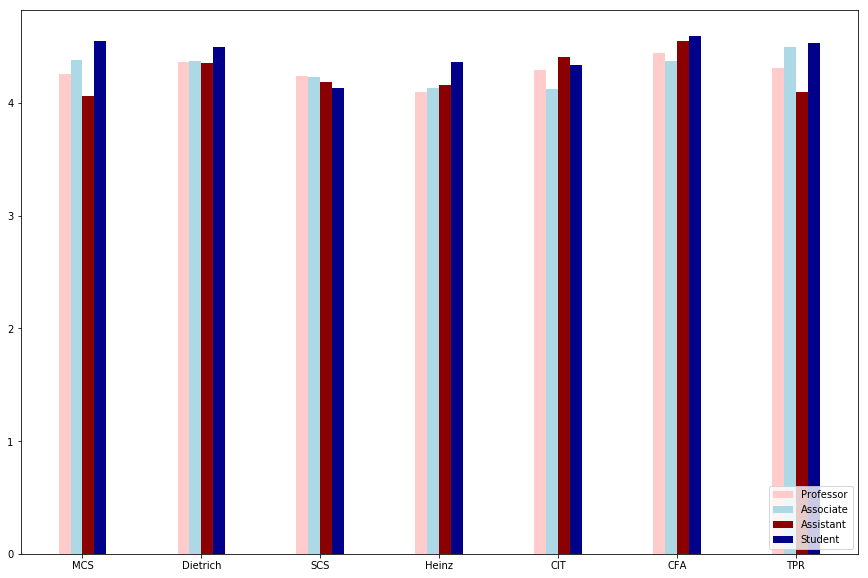

In [24]:
schools = ["MCS", "Dietrich", "SCS", "Heinz", "CIT", "CFA", "TPR"]
csvs = [df_2019MCS_info_merged, df_2019Dietrich_info_merged, df_2019SCS_info_merged, 
        df_2019Heinz_info_merged, df_2019CIT_info_merged, df_2019CFA_info_merged, df_2019TPR_info_merged]

#schools = ["Dietrich", "SCS", "Heinz"]
#csvs = [df_2019Dietrich_info_merged, df_2019SCS_info_merged, df_2019Heinz_info_merged]

proList = []
assoList = []
assistList = []
studentList = []

for file in csvs:
    data = getTitle(file, 0)
    proList.append(sum(data)/len(data))
    data = getTitle(file, 1)
    assoList.append(sum(data)/len(data))
    data = getTitle(file, 2)
    assistList.append(sum(data)/len(data))
    data = getTitle(file, 3)
    studentList.append(sum(data)/len(data))


N = len(schools)

ind = np.arange(N)  # the x locations for the groups
width = 0.1      # the width of the bars

fig, ax = plt.subplots(figsize=(15, 10))
bar1 = ax.bar(ind, proList, width, color='#ffcccb')
bar2 = ax.bar(ind + width, assoList, width, color='#add8e6')
bar3 = ax.bar(ind + width+width, assistList, width, color='#8b0000')
bar4 = ax.bar(ind + width+width+width, studentList, width, color='#00008b')

# add some text for labels, title and axes ticks
ax.set_xticks(ind + 3*width/2)
ax.set_xticklabels(schools)

ax.legend((bar1[0], bar2[0], bar3[0], bar4[0]), ('Professor', 'Associate', 'Assistant', 'Student'), loc=4)

plt.show()

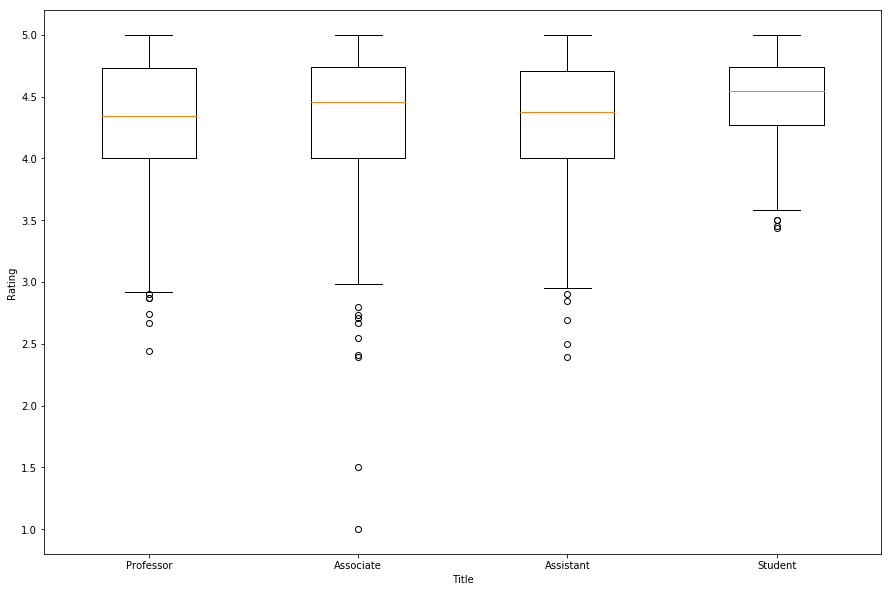

In [25]:
schools = ["MCS", "Dietrich", "SCS", "Heinz", "CIT", "CFA", "TPR"]
csvs = [df_2019MCS_info_merged, df_2019Dietrich_info_merged, df_2019SCS_info_merged, 
        df_2019Heinz_info_merged, df_2019CIT_info_merged, df_2019CFA_info_merged, df_2019TPR_info_merged]

#schools = ["Dietrich", "SCS", "Heinz"]
#csvs = [df_2019Dietrich_info_merged, df_2019SCS_info_merged, df_2019Heinz_info_merged]

pos = {0: [], 1: [], 2: [], 3: []}

for file in csvs:
    for x in range(4):
        data = getTitle(file, x)
        pos[x] += data

area = np.pi*(10)**2

# Plot
fig, ax = plt.subplots(figsize=(15,10))

ax.boxplot(pos.values())
ax.set_xticklabels(["Professor","Associate","Assistant","Student"])

plt.xlabel("Title")
plt.ylabel("Rating")
plt.show()

## How has the 'Hrs Per Week' changed over the years?

We are curious to know how the hours per week students have to invest in their classes has changed over the years. We are also interested in comparing the change in hours per week over the years between the undergraduate and graduate courses.

To start, we seperate our data by undergraduate and graduate courses.

In [26]:
df_grad = df[df['Level'] == "Graduate"]
df_undergrad = df[df['Level'] == "Undergraduate"]

avg_grad_fce = df_grad.groupby(["Year", "College"], as_index=False).mean()
avg_undergrad_fce = df_undergrad.groupby(["Year", "College"], as_index=False).mean()


Next, we create a line graph to observe the trend over time

### Undergraduate Students

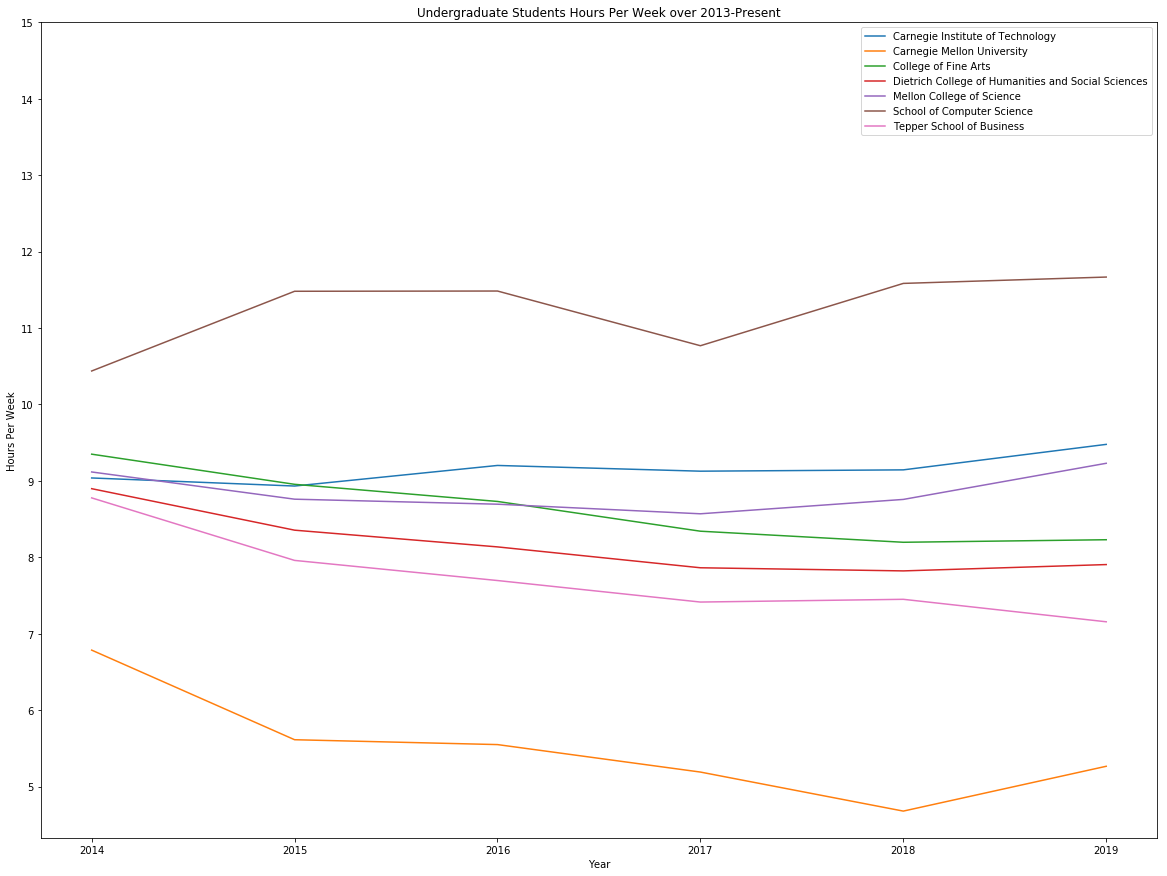

In [27]:
avg_undergrad_fce = avg_undergrad_fce.groupby(["Year", "College"], as_index=False).mean()
avg_undergrad_fce = avg_undergrad_fce[avg_undergrad_fce["Year"] > 2013]
avg_undergrad_fce = avg_undergrad_fce[["Year", "College","Hrs Per Week"]]

data = {}
years = set()

for index, row in avg_undergrad_fce.iterrows():
    col = row["College"]
    if col in data:
        data[col].append(row["Hrs Per Week"])
    else:
        data[col] = [row["Hrs Per Week"]]
    years.add(row["Year"])

years = list(years)
years.sort()

plt.figure(figsize=(20,15))

for d in data:
    if(len(data[d]) == len(years)):
        plt.plot(years, data[d], label = d.strip())
        plt.legend()

plt.xlabel('Year')
plt.ylabel('Hours Per Week')
plt.title("Undergraduate Students Hours Per Week over 2013-Present")
plt.yticks(np.arange(5, 16, step=1))

plt.show()

### Graduate Students

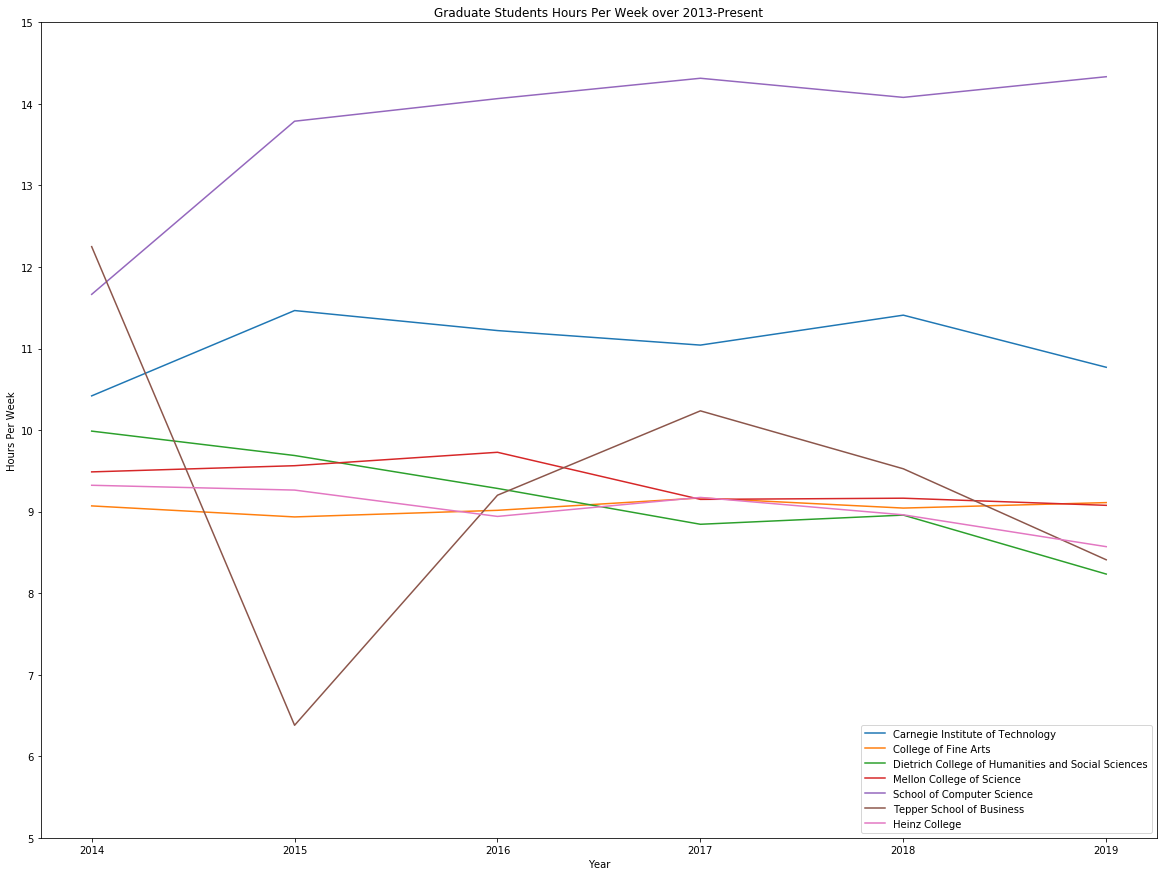

In [28]:
avg_grad_fce = avg_grad_fce.groupby(["Year", "College"], as_index=False).mean()
avg_grad_fce = avg_grad_fce[avg_grad_fce["Year"] > 2013]
avg_grad_fce = avg_grad_fce[["Year", "College","Hrs Per Week"]]

data = {}
years = set()

for index, row in avg_grad_fce.iterrows():
    col = row["College"]
    if col in data:
        data[col].append(row["Hrs Per Week"])
    else:
        data[col] = [row["Hrs Per Week"]]
    years.add(row["Year"])

years = list(years)
years.sort()

plt.figure(figsize=(20,15))

for d in data:
    if(len(data[d]) == len(years)):
        plt.plot(years, data[d], label = d.strip())
        plt.legend()

        
# add some text for labels, title and axes ticks
plt.xlabel('Year')
plt.ylabel('Hours Per Week')
plt.title("Graduate Students Hours Per Week over 2013-Present")
plt.yticks(np.arange(5, 16, step=1))

plt.show()

There are interesting trends when comparing the two graphs. 

We find that courses from the School of Computer Science consistently tend to have the highest hours per week over the years for both graphs. 

The striking difference between the two graphs are that the graduate data seems to be less consistent throughout the years in comparison to the undergraduate data.

## Which variable affects the `Overall course rate` the most?

When viewing how to improve the course experience for students, we are interested in knowing what the students tend to value the most. To do this, we create a correlation map:

/Users/chen/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


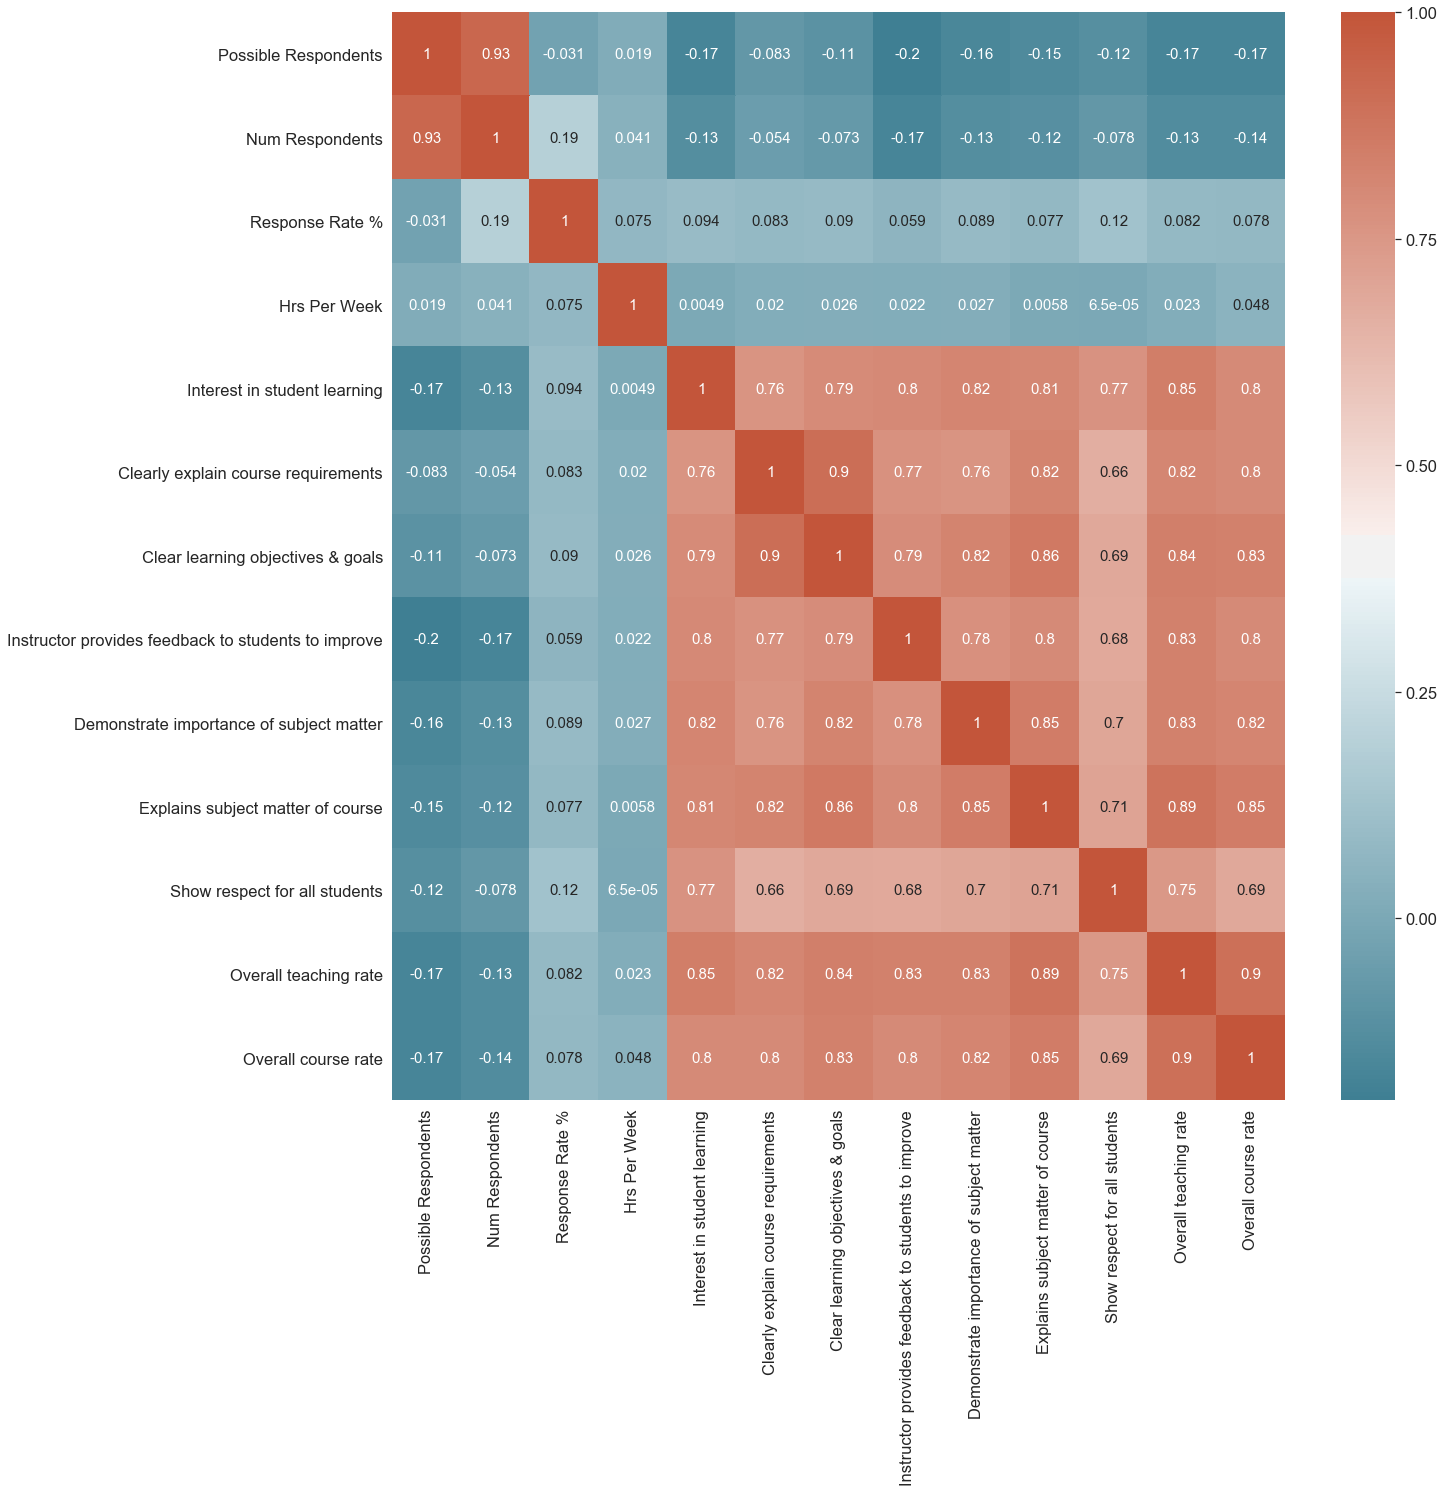

In [29]:
# sns.palplot(sns.color_palette("BrBG", 10))
plt.figure(figsize = (20,20))
corr_lst = list(df.select_dtypes(include=['int', 'float']).columns)
corr_df = df[corr_lst]
try:
    corr_df.drop("Year", axis=1, inplace=True)
except:
    pass
corr = corr_df.corr()
sns.set(font_scale=1.5)
ax = sns.heatmap(corr, cmap=sns.diverging_palette(220, 20, as_cmap=True),
                 annot=True, annot_kws={"size": 15})

Surprisingly, we find that the number of `Hrs per week` a student needs to invest in the class does not seem to affect the `Overall course rating`. From this map, we find that the `Overall teaching rate` and the `Explains subject matter of course` contributes the most to the `Overall course rating`. This leads us to believe it is the instructor which affects a course experience the most rather than the nature of the course itself (i.e. the belief that a course has a low rating due to it being difficult/time-consuming is not supported by this map).

We want to see how significant is the relationship between `Overall course rate` with `Overall teaching rate` and `Explains subject matter of course` is. To do this, we conduct a T-Test.

In [30]:
print(ttest_ind(df['Overall teaching rate'], df["Overall course rate"]))
print(ttest_ind(df['Explains subject matter of course'], df["Overall course rate"]))

Ttest_indResult(statistic=17.30246219571182, pvalue=5.6568799702218715e-67)
Ttest_indResult(statistic=22.44916459738248, pvalue=2.4761995265321016e-111)


We find each of the T-Tests yield a p-value of less than 0.05, meaning that this finding is statistically significant.  

## Do higher level courses get rated higher than lower level courses?

We are curious to know whether or not higher level courses tend to be rated higher than lower level courses. While higher level courses tend to be more difficult in terms of material, the course sizes tend to be much smaller than lower level courses. 

For this analysis, define the level of a course to be the third digit of the Course ID. For instance, 15-122 is a level 1 course whereas 10-703 is a level 7 course.

We start by plotting the mean of of each course level within each department:

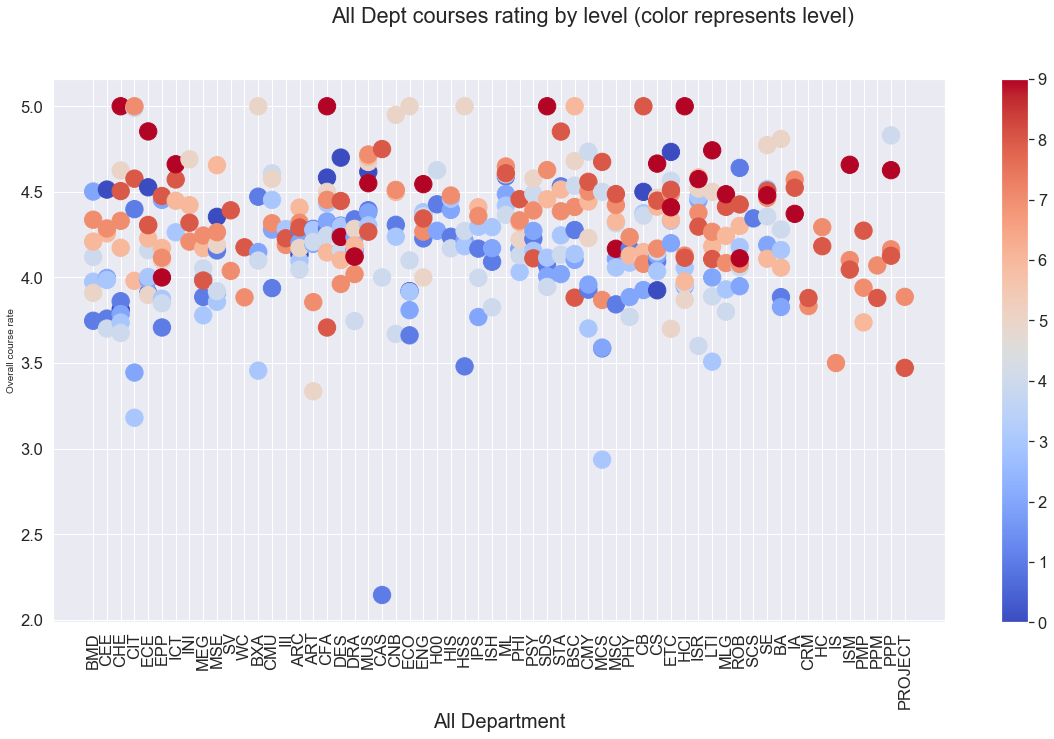

In [31]:
df_dept = df.copy()
def f(x):
    # There are different course listing in the past
    # such as "FA14-12-100" for CIT
    # so here we preprocess these data and create a column for the course ID level
    if x.startswith("F"):
        lst = x.split("-")
        x = lst[-2]+lst[-1]
    x = x[-3:]
    x = int(x)//100
    return (x)
df_dept["Course ID Level"] = df_dept["Course ID"].apply(f)

df_dept_plot = df_dept.groupby(["College", "Dept", "Course ID Level"], as_index=False).mean()
df_dept_plot_selected = df_dept_plot[["College", "Dept", "Course ID Level", "Overall course rate"]]
df_dept_plot_selected["College"].unique()
df_dept_plot_All = df_dept_plot_selected.copy()
min_ID = df_dept_plot_All["Course ID Level"].min()
max_ID = df_dept_plot_All["Course ID Level"].max()
plt_size = 10
fig, ax = plt.subplots(figsize=(2*plt_size,plt_size))
fig.suptitle('All Dept courses rating by level (color represents level)')
ax.set_ylabel("Overall course rate", fontsize=plt_size)
ax.set_xlabel("All Department", fontsize=2*plt_size)
ax.scatter(df_dept_plot_All["Dept"], 
           df_dept_plot_All["Overall course rate"], 
           c = df_dept_plot_All["Course ID Level"], 
           cmap = "coolwarm",s=plt_size*30)

# Alle from https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=min_ID, vmax=max_ID))
# need to "fake" an array for, otherwise throws an error
sm._A = []
plt.colorbar(sm)
plt.xticks(rotation=90)
plt.show()

Interestingly, we find that the red (representing higher level courses) tend to be plotted above the blue (representing the lower level courses). We want to test for the significance of this phenomenon. To test for signifiance, we conduct a T-Test.

In [32]:
print("Correlation between All's Course ID Level and Overall Course Rating is",\
      df_dept_plot_All['Course ID Level'].corr(df_dept_plot_All["Overall course rate"]))
ttest_ind(df_dept_plot_All['Course ID Level'], df_dept_plot_All["Overall course rate"])

Correlation between All's Course ID Level and Overall Course Rating is 0.28853154749941035


Ttest_indResult(statistic=2.9730476863591964, pvalue=0.0030459169351938816)

It seems that in the scope of all CMU departments, the `Course ID Level` and the `Overall Course Rating` is **positively correlated** with a **statistically significant p-value** of around **0.003**.

## Conclusion

By applying data science techniques to the Faculty Course Evaulations (FCEs) and other scrapped data, we have found some interesting results.